# Texas Pandas Examples

This script creates county-level choropleth maps for Texas demographic data. It creates some basic classes and walks through some use cases. City and county shapefiles were created with ArcGIS and have not been included. Colors were chosen using Color Brewer 2.0 (http://colorbrewer2.org/).
<br/><br/>
All data is publicly available. The data file has been downloaded from the Texas State Data Center on 8/10/2016 (http://osd.texas.gov/Data/TPEPP/Projections/). The data comprises 2014 Population Projections with a Full 2000-10 Migration Rate. 

In [48]:
# standard library
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.mlab import csv2rec
from matplotlib.cbook import get_sample_data

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option("display.max_rows",10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sets up some variables. A census api key must be specified here, as must the output path for storing the map image files.

In [2]:
OUTPATH = os.path.expanduser('~/Desktop/Example_Files/')
CURR_PATH = (os.path.realpath(''))

TSDC_FILE = os.path.normpath(os.path.join(CURR_PATH,
    'Data_Files/TSDC_PopulationProj_County_AgeGroup Yr2014 - 1.0ms.xlsx'))

<b>Loading Data From Excel</b>


Let's load and clean some data. First, load the file into a pandas dataframe.

<i>A <b>DataFrame</b> is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dict of Series objects.</i> --http://pandas.pydata.org/

In [3]:
pop_data = pd.read_excel(TSDC_FILE)
print('the dimensions are in rows, cols: ', pop_data.shape)
pop_data

('the dimensions are in rows, cols: ', (1530, 20))


,FIPS,area_name,migration_scenario,year,age_group,total,total_male,total_female,total_anglo,anglo_male,anglo_female,total_black,black_male,black_female,total_hispanic,hispanic_male,hispanic_female,total_other,other_male,other_female
0,0,State of Texas,1.0 Scen,2014,ALL,27161942,13499310,13662632,11624881,5753306,5871575,3114187,1506024,1608163,10740456,5417985,5322471,1682418,821995,860423
1,0,State of Texas,1.0 Scen,2014,<18,7216132,3691030,3525102,2330976,1195370,1135606,824890,420626,404264,3578159,1829787,1748372,482107,245247,236860
2,0,State of Texas,1.0 Scen,2014,18-24,2790003,1445762,1344241,964491,495432,469059,354617,180591,174026,1302563,683133,619430,168332,86606,81726
3,0,State of Texas,1.0 Scen,2014,25-44,7569054,3800392,3768662,2934438,1479361,1455077,889282,426914,462368,3206202,1635324,1570878,539132,258793,280339
4,0,State of Texas,1.0 Scen,2014,45-64,6500397,3188648,3311749,3381136,1672570,1708566,778233,368572,409661,1976562,974421,1002141,364466,173085,191381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,507,Zavala County,1.0 Scen,2014,<18,3714,1851,1863,127,55,72,13,6,7,3566,1787,1779,8,3,5
1526,507,Zavala County,1.0 Scen,2014,18-24,1406,732,674,43,24,19,5,1,4,1356,707,649,2,0,2
1527,507,Zavala County,1.0 Scen,2014,25-44,2829,1495,1334,141,73,68,8,6,2,2674,1413,1261,6,3,3
1528,507,Zavala County,1.0 Scen,2014,45-64,2637,1273,1364,169,88,81,6,4,2,2450,1175,1275,12,6,6


<b>Selecting Columns</b>

There's a lot of extra columns we don't need--we're really only interested in what will go in our report. Let's slice the data to keep only the relevant columns by using lists

In [4]:
cols_to_keep = [col for col in pop_data.columns if 'total' in col]
cols_to_keep = ['FIPS', 'area_name', 'age_group'] + cols_to_keep
cols_to_keep

['FIPS',
 'area_name',
 'age_group',
 u'total',
 u'total_male',
 u'total_female',
 u'total_anglo',
 u'total_black',
 u'total_hispanic',
 u'total_other']

Ah, much better...

In [5]:
pop_data = pop_data.loc[:,cols_to_keep]
pop_data = pop_data.drop('total_other', axis=1)
print('the dimensions are in rows, cols: ', pop_data.shape)
pop_data

('the dimensions are in rows, cols: ', (1530, 9))


,FIPS,area_name,age_group,total,total_male,total_female,total_anglo,total_black,total_hispanic
0,0,State of Texas,ALL,27161942,13499310,13662632,11624881,3114187,10740456
1,0,State of Texas,<18,7216132,3691030,3525102,2330976,824890,3578159
2,0,State of Texas,18-24,2790003,1445762,1344241,964491,354617,1302563
3,0,State of Texas,25-44,7569054,3800392,3768662,2934438,889282,3206202
4,0,State of Texas,45-64,6500397,3188648,3311749,3381136,778233,1976562
...,...,...,...,...,...,...,...,...,...
1525,507,Zavala County,<18,3714,1851,1863,127,13,3566
1526,507,Zavala County,18-24,1406,732,674,43,5,1356
1527,507,Zavala County,25-44,2829,1495,1334,141,8,2674
1528,507,Zavala County,45-64,2637,1273,1364,169,6,2450


<b>Selecting Rows</b>

We're not interested in state level data, so let's drop that from our dataframe

In [6]:
pop_data= pop_data[pop_data['FIPS'] != 0]
pop_data

,FIPS,area_name,age_group,total,total_male,total_female,total_anglo,total_black,total_hispanic
6,1,Anderson County,ALL,59991,36443,23548,35957,12456,10242
7,1,Anderson County,<18,11542,5942,5600,6555,1707,2756
8,1,Anderson County,18-24,4747,2847,1900,2526,951,1152
9,1,Anderson County,25-44,18335,12981,5354,8965,4968,4097
10,1,Anderson County,45-64,17014,10700,6314,11002,3868,1880
...,...,...,...,...,...,...,...,...,...
1525,507,Zavala County,<18,3714,1851,1863,127,13,3566
1526,507,Zavala County,18-24,1406,732,674,43,5,1356
1527,507,Zavala County,25-44,2829,1495,1334,141,8,2674
1528,507,Zavala County,45-64,2637,1273,1364,169,6,2450


What if we just want the total population across ages for each county and each column.

In [42]:
total_data = pop_data[pop_data['age_group'] == 'ALL']
print('the dimensions are in rows, cols: ', total_data.shape)
total_data

('the dimensions are in rows, cols: ', (254, 9))


,FIPS,area_name,age_group,total,total_male,total_female,total_anglo,total_black,total_hispanic
6,1,Anderson County,ALL,59991,36443,23548,35957,12456,10242
12,3,Andrews County,ALL,15861,7942,7919,7211,202,8114
18,5,Angelina County,ALL,89854,44325,45529,54815,13348,19441
24,7,Aransas County,ALL,24431,12061,12370,16874,265,6358
30,9,Archer County,ALL,9416,4711,4705,8437,34,781
...,...,...,...,...,...,...,...,...,...
1500,499,Wood County,ALL,44655,21974,22681,37385,2126,4208
1506,501,Yoakum County,ALL,8531,4254,4277,3073,59,5284
1512,503,Young County,ALL,19074,9482,9592,14962,227,3529
1518,505,Zapata County,ALL,15241,7686,7555,844,11,14324


<b>Selecting on Rows and Columns to Find Total Children Under 18</b>

We can pivot the data easily

In [29]:
pivoted_data = pop_data.pivot('FIPS', 'age_group', 'total')
pivoted_data.reset_index(inplace=True)
print('the dimensions are in rows, cols: ', pivoted_data.shape)
pivoted_data

('the dimensions are in rows, cols: ', (254, 7))


age_group,FIPS,18-24,25-44,45-64,65+,<18,ALL
0,1,4747,18335,17014,8353,11542,59991
1,3,1519,3984,3943,1852,4563,15861
2,5,8370,21733,22633,13407,23711,89854
3,7,1725,4278,7113,6808,4507,24431
4,9,868,1928,2900,1609,2111,9416
...,...,...,...,...,...,...,...
249,499,3437,7883,12501,12129,8705,44655
250,501,816,2050,2020,1051,2594,8531
251,503,1519,4093,5287,3638,4537,19074
252,505,1745,3751,2834,1704,5207,15241


Next we just select and rename the columns that we want

In [23]:
pivoted_data = pivoted_data[['FIPS', '<18']]
pivoted_data.columns = ['FIPS', 'total_children']  # rename
print('the dimensions are in rows, cols: ', pivoted_data.shape)
pivoted_data

('the dimensions are in rows, cols: ', (254, 2))


,FIPS,total_children
0,1,11542
1,3,4563
2,5,23711
3,7,4507
4,9,2111
...,...,...
249,499,8705
250,501,2594
251,503,4537
252,505,5207


Or we can select rows based on a condition as we did before and select and rename the columns that we want.

In [36]:
children_data = pop_data[pop_data['age_group'] == '<18'][['FIPS', 'total']]
children_data.columns = ['FIPS', 'total_children']  # rename
print('the dimensions are in rows, cols: ', children_data.shape)
children_data

('the dimensions are in rows, cols: ', (254, 2))


,FIPS,total_children
7,1,11542
13,3,4563
19,5,23711
25,7,4507
31,9,2111
...,...,...
1501,499,8705
1507,501,2594
1513,503,4537
1519,505,5207


And let's add our children column back in with a dataframe merge

In [43]:
total_data = pd.merge(total_data, children_data, how='left', on='FIPS')
print('the dimensions are in rows, cols: ', total_data.shape)
total_data

('the dimensions are in rows, cols: ', (254, 10))


,FIPS,area_name,age_group,total,total_male,total_female,total_anglo,total_black,total_hispanic,total_children
0,1,Anderson County,ALL,59991,36443,23548,35957,12456,10242,11542
1,3,Andrews County,ALL,15861,7942,7919,7211,202,8114,4563
2,5,Angelina County,ALL,89854,44325,45529,54815,13348,19441,23711
3,7,Aransas County,ALL,24431,12061,12370,16874,265,6358,4507
4,9,Archer County,ALL,9416,4711,4705,8437,34,781,2111
...,...,...,...,...,...,...,...,...,...,...
249,499,Wood County,ALL,44655,21974,22681,37385,2126,4208,8705
250,501,Yoakum County,ALL,8531,4254,4277,3073,59,5284,2594
251,503,Young County,ALL,19074,9482,9592,14962,227,3529,4537
252,505,Zapata County,ALL,15241,7686,7555,844,11,14324,5207


<b>Doing Operations on Columns</b>

What if we want our category total columns represented as ratios?

In [45]:
new_data = total_data.iloc[:,:4].join(total_data.iloc[:,4:].div(total_data.total, axis='index'), rsuffix='_ratio')
new_data

,FIPS,area_name,age_group,total,total_male,total_female,total_anglo,total_black,total_hispanic,total_children
0,1,Anderson County,ALL,59991,0.607474,0.392526,0.599373,0.207631,0.170726,0.192396
1,3,Andrews County,ALL,15861,0.500725,0.499275,0.454637,0.012736,0.511569,0.287687
2,5,Angelina County,ALL,89854,0.493300,0.506700,0.610045,0.148552,0.216362,0.263884
3,7,Aransas County,ALL,24431,0.493676,0.506324,0.690680,0.010847,0.260243,0.184479
4,9,Archer County,ALL,9416,0.500319,0.499681,0.896028,0.003611,0.082944,0.224193
...,...,...,...,...,...,...,...,...,...,...
249,499,Wood County,ALL,44655,0.492084,0.507916,0.837196,0.047609,0.094234,0.194939
250,501,Yoakum County,ALL,8531,0.498652,0.501348,0.360216,0.006916,0.619388,0.304068
251,503,Young County,ALL,19074,0.497116,0.502884,0.784419,0.011901,0.185016,0.237863
252,505,Zapata County,ALL,15241,0.504298,0.495702,0.055377,0.000722,0.939833,0.341644


# Matplotlib Gallery Examples

Seriously, these are just taken from http://matplotlib.org/gallery.html. This is a great resource to get some guidance on plotting with matplotlib!

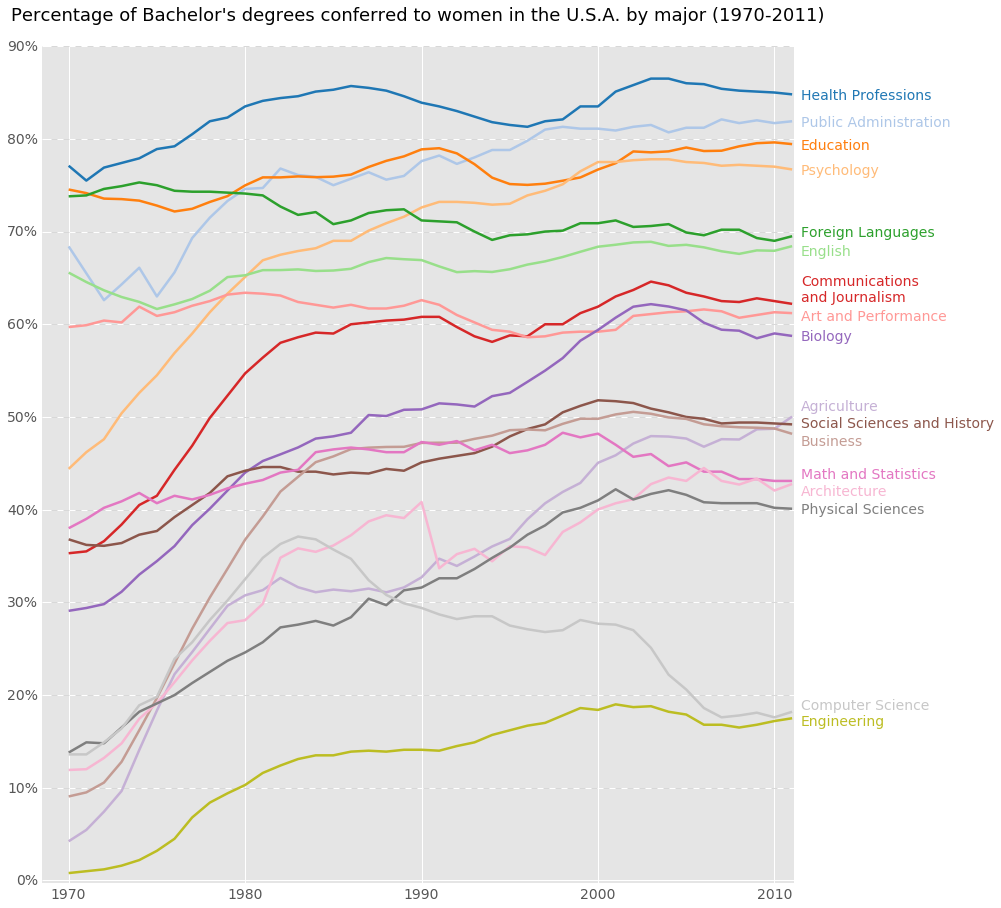

In [58]:
fname = get_sample_data('percent_bachelors_degrees_women_usa.csv')
gender_degree_data = csv2rec(fname)

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

# You typically want your plot to be ~1.33x wider than tall. This plot
# is a rare exception because of the number of lines being plotted on it.
# Common sizes: (10, 7.5) and (12, 9)
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Limit the range of the plot to only where the data is.
# Avoid unnecessary whitespace.
plt.xlim(1968.5, 2011.1)
plt.ylim(-0.25, 90)

# Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
plt.xticks(range(1970, 2011, 10), fontsize=14)
plt.yticks(range(0, 91, 10), ['{0}%'.format(x)
                              for x in range(0, 91, 10)], fontsize=14)

# Provide tick lines across the plot to help your viewers trace along
# the axis ticks. Make sure that the lines are light and small so they
# don't obscure the primary data lines.
for y in range(10, 91, 10):
    plt.plot(range(1969, 2012), [y] * len(range(1969, 2012)), '--',
             lw=0.5, color='black', alpha=0.3)

# Remove the tick marks; they are unnecessary with the tick lines we just
# plotted.
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')

# Now that the plot is prepared, it's time to actually plot the data!
# Note that I plotted the majors in order of the highest % in the final year.
majors = ['Health Professions', 'Public Administration', 'Education',
          'Psychology', 'Foreign Languages', 'English',
          'Communications\nand Journalism', 'Art and Performance', 'Biology',
          'Agriculture', 'Social Sciences and History', 'Business',
          'Math and Statistics', 'Architecture', 'Physical Sciences',
          'Computer Science', 'Engineering']

y_offsets = {'Foreign Languages': 0.5, 'English': -0.5,
             'Communications\nand Journalism': 0.75,
             'Art and Performance': -0.25, 'Agriculture': 1.25,
             'Social Sciences and History': 0.25, 'Business': -0.75,
             'Math and Statistics': 0.75, 'Architecture': -0.75,
             'Computer Science': 0.75, 'Engineering': -0.25}

for rank, column in enumerate(majors):
    # Plot each line separately with its own color.
    column_rec_name = column.replace('\n', '_').replace(' ', '_').lower()

    line = plt.plot(gender_degree_data.year,
                    gender_degree_data[column_rec_name],
                    lw=2.5,
                    color=color_sequence[rank])

    # Add a text label to the right end of every line. Most of the code below
    # is adding specific offsets y position because some labels overlapped.
    y_pos = gender_degree_data[column_rec_name][-1] - 0.5

    if column in y_offsets:
        y_pos += y_offsets[column]

    # Again, make sure that all labels are large enough to be easily read
    # by the viewer.
    plt.text(2011.5, y_pos, column, fontsize=14, color=color_sequence[rank])

# Make the title big enough so it spans the entire plot, but don't make it
# so big that it requires two lines to show.

# Note that if the title is descriptive enough, it is unnecessary to include
# axis labels; they are self-evident, in this plot's case.
plt.title('Percentage of Bachelor\'s degrees conferred to women in '
          'the U.S.A. by major (1970-2011)\n', fontsize=18, ha='center')

# Show the plot
plt.show()

In [55]:
plt.style.use('fivethirtyeight')
plt.show()
plt

<module 'matplotlib.pyplot' from 'c:\anaconda\lib\site-packages\matplotlib\pyplot.pyc'>

And not to traumatize people too much after the fact, but I'll bet you were all checking FiveThirtyEight a bunch up until recently.

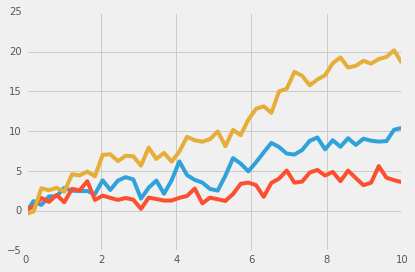

In [62]:
"""
This shows an example of the "fivethirtyeight" styling, which
tries to replicate the styles from FiveThirtyEight.com.
"""

from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(0, 10)

with plt.style.context('fivethirtyeight'):
    plt.plot(x, np.sin(x) + x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 0.5 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 2 * x + np.random.randn(50))


plt.show()

Or if you're so inclined

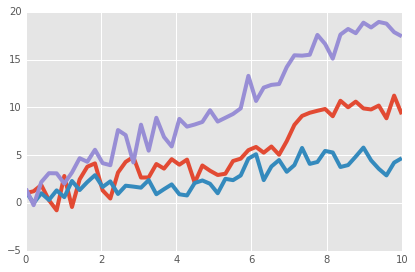

In [63]:
"""
This is the same plto with ggplot styling
"""

from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(0, 10)

with plt.style.context('ggplot'):
    plt.plot(x, np.sin(x) + x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 0.5 * x + np.random.randn(50))
    plt.plot(x, np.sin(x) + 2 * x + np.random.randn(50))


plt.show()